# Prosper Loan Data
## by Alejandro Rodriguez Martinez

## Preliminary Wrangling

> This dataset contains information on loans given to individuals. There are 113937 entries with 81 variables each. For this analysis only a subset of them will be chosen. Interesting variables include Borrower's APR, Loan Status or Credit score to name a few

In [170]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

Let's load the dataset and get an overview of the main properties for the data.

In [171]:
loan = pd.read_csv('prosperLoanData.csv')
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

There are a few columns that are IDs, these can be removed. IDs may be of use when joining different dataframes or when drawing conclusions for specific individuals. However this analysis is rather on the aggregated side. The idea is to find out relationship between variables in the data set as a whole and so IDs are of no use in this case. However before removing unique IDs, let's make sure there are no duplicates

In [172]:
listingkeyfilt= [i for i,j in loan.ListingKey.value_counts().iteritems() if j > 1]
len(listingkeyfilt)   # ProsperScore seems to be not reliable

827

It seems that there are many duplicates for column ListingKey. However when using pandas duplicated() method, pandas seems to suggest that there are no duplicates.


In [173]:
sum(loan.duplicated())

0

This leads me to think that there are columns that are different for the same ListingKey ID. Visual inspection in Excel reveals that **ProsperScore** column contains different numbers for what otherwise would be an duplicate entry. To me it doesn't make sense to allocate different risk scores to the same data. Therefore this column seems unreliable and it will be a column we will drop for our analysis.

In [192]:
loan_clean = loan.drop('ProsperScore',axis=1)
sum(loan_clean.ListingKey.duplicated())

871

It can be observed above that now there are 871 rows that are duplicated and thus can be removed. Let's do so

In [193]:
print(loan_clean.shape[0])
loan_clean.drop_duplicates(inplace=True)
print(loan_clean.shape[0])

113937
113066


Other column that show IDs are: ListingNumber, LoanKey, LoanNumber. Let's remove them

In [194]:
for colnametoDrop in ['ListingKey','ListingNumber', 'LoanKey', 'LoanNumber']:
    loan_clean.drop(colnametoDrop,axis=1,inplace=True)
loan_clean.shape

(113066, 76)

MemberKey and GroupKey columns are not unique, but we are not interested in particular customers, so these columns can be removed as well

In [195]:
loan_clean.drop(['MemberKey','GroupKey'],axis=1,inplace=True)
loan_clean.shape

(113066, 74)

There are some other columns that contain too many NaN values, when deciding which columns to analyse the ones that contain less information will be discarded. However since there are so many columns that need to be removed, it may be more sensible to select the subset of columns that we want to analyse.
For starters, let's narrow down the number of variables to 17 columns that we can group in the following manner   

**Numerical Discrete**
- 'EmploymentStatusDuration' 
- 'CreditScoreRangeUpper'
- 'DelinquenciesLast7Years'
- 'RevolvingCreditBalance'
- 'AvailableBankcardCredit'
- 'LoanOriginalAmount'  

**Numerical Continuous**
- 'BorrowerAPR' 
- 'LenderYield'
- 'DebtToIncomeRatio'
- 'MonthlyLoanPayment'  

**Categorical/ Nominal**
- 'EmploymentStatus'    -  9 categories
- 'IsBorrowerHomeowner' - 2 categories
- 'LoanStatus'    - 12 categories    

**Ordinal**
- 'Term'
- 'IncomeRange'
- 'CreditGrade'                         
- 'ProsperRating (Alpha)'               

In [196]:
columnsToKeep = ['EmploymentStatusDuration','CreditScoreRangeUpper','DelinquenciesLast7Years','RevolvingCreditBalance','AvailableBankcardCredit','LoanOriginalAmount','MonthlyLoanPayment','BorrowerAPR','LenderYield','DebtToIncomeRatio','EmploymentStatus','IsBorrowerHomeowner','LoanStatus','Term','IncomeRange','CreditGrade','ProsperRating (Alpha)']
loan_clean.drop([x for x in loan_clean.columns if x not in columnsToKeep],axis=1,inplace=True)
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 17 columns):
CreditGrade                 28953 non-null object
Term                        113066 non-null int64
LoanStatus                  113066 non-null object
BorrowerAPR                 113041 non-null float64
LenderYield                 113066 non-null float64
ProsperRating (Alpha)       83982 non-null object
EmploymentStatus            110811 non-null object
EmploymentStatusDuration    105441 non-null float64
IsBorrowerHomeowner         113066 non-null bool
CreditScoreRangeUpper       112475 non-null float64
DelinquenciesLast7Years     112076 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           104594 non-null float64
IncomeRange                 113066 non-null object
LoanOriginalAmount          113066 non-null int64
MonthlyLoanPayment          113066 non-null float64
dtypes: bool(1), fl

Interestingly, the two columns that contain fewer entries, namely Credit Grade and Prosper Rating, complement one another. It can be seen below that they both never contain values for the same entry and only a few entries are missing both variables. 

In [197]:
print('Both columns are null at the same time: {}'.format(sum(loan_clean['CreditGrade'].isna() & loan_clean['ProsperRating (Alpha)'].isna())))
print('Both columns are not null at the same time: {}'.format(sum(loan_clean['CreditGrade'].notna() & loan_clean['ProsperRating (Alpha)'].notna())))

Both columns are null at the same time: 131
Both columns are not null at the same time: 0


Therefore we can join both columns into one, let's keep the name credit grade

In [198]:
loan_clean['CreditGrade'].where(loan_clean['CreditGrade'].notna(),loan_clean['ProsperRating (Alpha)'],inplace=True)
loan_clean.drop('ProsperRating (Alpha)',axis=1,inplace=True)
print(loan_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 16 columns):
CreditGrade                 112935 non-null object
Term                        113066 non-null int64
LoanStatus                  113066 non-null object
BorrowerAPR                 113041 non-null float64
LenderYield                 113066 non-null float64
EmploymentStatus            110811 non-null object
EmploymentStatusDuration    105441 non-null float64
IsBorrowerHomeowner         113066 non-null bool
CreditScoreRangeUpper       112475 non-null float64
DelinquenciesLast7Years     112076 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           104594 non-null float64
IncomeRange                 113066 non-null object
LoanOriginalAmount          113066 non-null int64
MonthlyLoanPayment          113066 non-null float64
dtypes: bool(1), float64(9), int64(2), object(4)
memory usage: 13.9+

Both Ordinal and categorical/nominal data could be casted as CategoricalDType. In this way it's clearer which variables are categorical and which ones are not.

In [199]:
loan_clean.CreditGrade.value_counts()
ordinal_var_dict = {'CreditGrade': ['NC','HR','E','D','C','B','A','AA'],
                    'Term':[12,36,60],
                    'IncomeRange':['Not displayed','Not employed','$0','$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']}

for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 16 columns):
CreditGrade                 112935 non-null category
Term                        113066 non-null category
LoanStatus                  113066 non-null object
BorrowerAPR                 113041 non-null float64
LenderYield                 113066 non-null float64
EmploymentStatus            110811 non-null object
EmploymentStatusDuration    105441 non-null float64
IsBorrowerHomeowner         113066 non-null bool
CreditScoreRangeUpper       112475 non-null float64
DelinquenciesLast7Years     112076 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           104594 non-null float64
IncomeRange                 113066 non-null category
LoanOriginalAmount          113066 non-null int64
MonthlyLoanPayment          113066 non-null float64
dtypes: bool(1), category(3), float64(9), int64(1), object(2)

It seems that there are some missing entries for some columns. Let's inspect *AvailableBankcardCredit* for example. This will help us determine whether those entries are candidates to remove or on the other hand they follow an specified pattern. Let's display a slice of them

In [200]:
 loan_clean[loan_clean.AvailableBankcardCredit.isna()].sample(20)

,CreditGrade,Term,LoanStatus,BorrowerAPR,LenderYield,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,IncomeRange,LoanOriginalAmount,MonthlyLoanPayment
52547,E,36,Completed,0.24502,0.2075,NaN,NaN,False,559.0,NaN,NaN,NaN,0.13594,Not displayed,2500,97.75
816,B,36,Defaulted,0.21438,0.1870,Not available,NaN,True,699.0,0.0,NaN,NaN,0.86000,Not displayed,8500,318.93
46382,HR,36,Chargedoff,0.18824,0.1450,Not available,NaN,True,519.0,34.0,NaN,NaN,0.20000,Not displayed,1000,35.65
91434,HR,36,Defaulted,0.28577,0.2450,Not available,NaN,False,479.0,29.0,NaN,NaN,0.02000,Not displayed,1225,50.01
76040,D,36,Completed,0.22945,0.2170,Not available,NaN,False,639.0,0.0,NaN,NaN,0.23000,Not displayed,10002,383.02
20418,A,36,Completed,0.10692,0.0950,Not available,NaN,True,739.0,0.0,NaN,NaN,0.35000,Not displayed,3000,96.80
63676,D,36,Completed,0.23036,0.2150,Not available,NaN,False,639.0,0.0,NaN,NaN,0.09000,Not displayed,1800,0.00
102494,E,36,Defaulted,0.29776,0.2850,Not available,NaN,False,579.0,0.0,NaN,NaN,0.29000,Not displayed,4000,167.62
74716,A,36,Completed,0.09427,0.0799,Not available,NaN,False,739.0,0.0,NaN,NaN,0.17000,Not displayed,6000,190.07
4156,E,36,Completed,0.17219,0.1600,Not available,NaN,False,599.0,0.0,NaN,NaN,0.07000,Not displayed,5000,177.02


In [201]:
 loan_clean[loan_clean.AvailableBankcardCredit.isna()].Term.value_counts()

36    7544
60       0
12       0
Name: Term, dtype: int64

It seems that those entries that contain missing values for bankcard credit also contain missing values for some other columns. Also, it seems that it can be safe to rename NaN for Not available in **EmploymentStatus** column. Also notice that all entries that do not contain information for AvailableBankcardCredit correspond to loans on 36-month term... This is perhaps something to be wary about when drawing conclusions. However, for this analysis and bearing in mind that there are many more entries for 36-month loans that for any of the other two categories, then let's remove these rows.
Another thing to note is that CreditGrade already contains a NaN value which is NC


In [202]:
loan_clean.EmploymentStatus.replace(np.nan,'Not available',inplace=True)
loan_clean.CreditGrade.replace(np.nan,'NC',inplace=True)
loan_clean.drop(loan_clean[loan_clean.AvailableBankcardCredit.isna()].index,axis=0,inplace=True)
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105522 entries, 0 to 113936
Data columns (total 16 columns):
CreditGrade                 105522 non-null category
Term                        105522 non-null category
LoanStatus                  105522 non-null object
BorrowerAPR                 105522 non-null float64
LenderYield                 105522 non-null float64
EmploymentStatus            105522 non-null object
EmploymentStatusDuration    105439 non-null float64
IsBorrowerHomeowner         105522 non-null bool
CreditScoreRangeUpper       105522 non-null float64
DelinquenciesLast7Years     105500 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           97172 non-null float64
IncomeRange                 105522 non-null category
LoanOriginalAmount          105522 non-null int64
MonthlyLoanPayment          105522 non-null float64
dtypes: bool(1), category(3), float64(9), int64(1), object(2)


EmploymentStatusDuration, RevolvingCreditBalance, DeliquenciesLast7Years and DebtToIncomeRatio are likely to impact the CreditGrade... Since all entries have an associated CreditGrade let's fill the missing gaps with the average value for the creditgrade group

In [203]:
colToFil = ['EmploymentStatusDuration', 'RevolvingCreditBalance', 'DelinquenciesLast7Years','DebtToIncomeRatio']
for col in colToFil:
    dummyValues = loan_clean.groupby('CreditGrade').mean().reset_index()[['CreditGrade',col]]
    valuesOnGrade = loan_clean[loan_clean[col].isna()].merge(dummyValues,how='left',on='CreditGrade')['{}_y'.format(col)]
    indexesToWrite = loan_clean[loan_clean[col].isna()].index
    loan_clean.loc[indexesToWrite,col] = valuesOnGrade.values
    loan_clean[loan_clean[col].isna()]
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105522 entries, 0 to 113936
Data columns (total 16 columns):
CreditGrade                 105522 non-null category
Term                        105522 non-null category
LoanStatus                  105522 non-null object
BorrowerAPR                 105522 non-null float64
LenderYield                 105522 non-null float64
EmploymentStatus            105522 non-null object
EmploymentStatusDuration    105522 non-null float64
IsBorrowerHomeowner         105522 non-null bool
CreditScoreRangeUpper       105522 non-null float64
DelinquenciesLast7Years     105522 non-null float64
RevolvingCreditBalance      105522 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           105522 non-null float64
IncomeRange                 105522 non-null category
LoanOriginalAmount          105522 non-null int64
MonthlyLoanPayment          105522 non-null float64
dtypes: bool(1), category(3), float64(9), int64(1), object(2)

Now, there are no more missing entries. Discrete values can therefore be converted to int

In [211]:
loan_clean.EmploymentStatusDuration = loan_clean.EmploymentStatusDuration.astype('int64')
loan_clean.CreditScoreRangeUpper = loan_clean.CreditScoreRangeUpper.astype('int64')
loan_clean.DelinquenciesLast7Years = loan_clean.DelinquenciesLast7Years.astype('int64')
loan_clean.RevolvingCreditBalance = loan_clean.RevolvingCreditBalance.astype('int64')
loan_clean.AvailableBankcardCredit = loan_clean.AvailableBankcardCredit.astype('int64')
loan_clean.LoanOriginalAmount = loan_clean.LoanOriginalAmount.astype('int64')
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105522 entries, 0 to 113936
Data columns (total 16 columns):
CreditGrade                 105522 non-null category
Term                        105522 non-null category
LoanStatus                  105522 non-null object
BorrowerAPR                 105522 non-null float64
LenderYield                 105522 non-null float64
EmploymentStatus            105522 non-null object
EmploymentStatusDuration    105522 non-null int64
IsBorrowerHomeowner         105522 non-null bool
CreditScoreRangeUpper       105522 non-null int64
DelinquenciesLast7Years     105522 non-null int64
RevolvingCreditBalance      105522 non-null int64
AvailableBankcardCredit     105522 non-null int64
DebtToIncomeRatio           105522 non-null float64
IncomeRange                 105522 non-null category
LoanOriginalAmount          105522 non-null int64
MonthlyLoanPayment          105522 non-null float64
dtypes: bool(1), category(3), float64(4), int64(6), object(2)
memory us

Let's check for outliers now

In [212]:
loan_clean.describe()

,BorrowerAPR,LenderYield,EmploymentStatusDuration,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,LoanOriginalAmount,MonthlyLoanPayment
count,105522.000000,105522.000000,105522.000000,105522.000000,105522.000000,1.055220e+05,105522.000000,105522.000000,105522.000000,105522.000000
mean,0.220380,0.183041,96.058831,710.200508,3.928792,1.759210e+04,11208.182028,0.276848,8543.270702,278.457870
std,0.081034,0.075078,94.395073,56.659748,9.800208,3.293661e+04,19847.681185,0.505246,6257.927037,192.044722
min,0.006530,-0.010000,0.000000,19.000000,0.000000,0.000000e+00,0.000000,0.000000,1000.000000,0.000000
25%,0.157130,0.123500,26.000000,679.000000,0.000000,3.102000e+03,876.000000,0.150000,4000.000000,138.370000
50%,0.211150,0.173000,67.000000,699.000000,0.000000,8.538000e+03,4090.000000,0.230000,7000.000000,228.240000
75%,0.285740,0.241100,137.000000,739.000000,3.000000,1.951950e+04,13165.000000,0.310000,12000.000000,376.750000
max,0.423950,0.340000,755.000000,899.000000,99.000000,1.435667e+06,646285.000000,10.010000,35000.000000,2251.510000


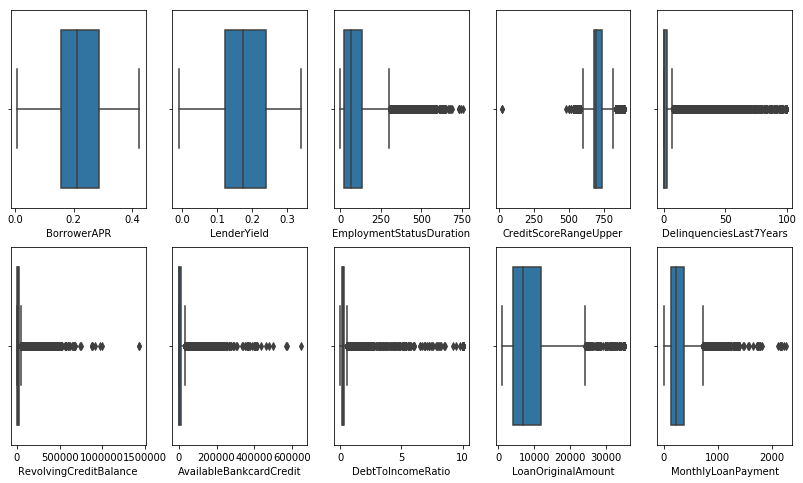

In [232]:
boxplotvarlist = ['BorrowerAPR','LenderYield','EmploymentStatusDuration','CreditScoreRangeUpper','DelinquenciesLast7Years','RevolvingCreditBalance','AvailableBankcardCredit','DebtToIncomeRatio','LoanOriginalAmount','MonthlyLoanPayment']
plt.figure(figsize=[14,8]);
for i,var in enumerate(boxplotvarlist):
    plt.subplot(2,5,i+1)
    sb.boxplot(data=loan_clean, x=var)

From the graph above it can be seen that some variables are really skewed, others are more evenly distributed. There is one though that seems to contain wrong values. **CreditScoreRangeUpper** seems to have unsually low values that I need to inspect. The other variables look somehow normal to me, so I will not inspect them further to look for outliers

In [233]:
loan_clean[loan_clean.CreditScoreRangeUpper < 250]

,CreditGrade,Term,LoanStatus,BorrowerAPR,LenderYield,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,IncomeRange,LoanOriginalAmount,MonthlyLoanPayment
794,NC,36,Completed,0.29776,0.285,Not available,74,False,19,2,12039,0,0.25,Not displayed,4000,167.62
109468,NC,36,Completed,0.12700,0.105,Not available,74,False,19,2,12039,0,0.25,Not displayed,2550,84.70


This inspection shows that most parameters have been filled in with mean values as the originals were probably missing. The fact that CreditScoreRangeUpper contains doggy values suggests that perhaps the whole entry is not reliable. Let's remove these two entries from the cleaned dataset

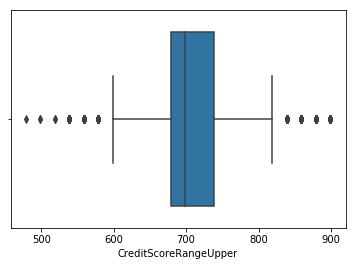

In [239]:
loan_clean.drop(loan_clean[loan_clean.CreditScoreRangeUpper < 250].index,axis=0,inplace=True)
sb.boxplot(data=loan_clean, x='CreditScoreRangeUpper');

Let's see what happens with non-numerical variables

In [249]:
loan_clean.describe(exclude = np.number)

,CreditGrade,Term,LoanStatus,EmploymentStatus,IsBorrowerHomeowner,IncomeRange
count,105520,105520,105520,105520,105520,105520
unique,8,3,12,8,2,8
top,C,36,Current,Employed,True,"$25,000-49,999"
freq,22642,79678,55730,66598,54523,31940


There is nothing relevante on this front...
**Data wrangling has been completed** and now we have a clean data set to work with. In this data set there is a good mix of all data types seen throughout the course. As described before there are discrete and continuous values as well as ordinal and categorical data.

### What is the structure of your dataset?

> Your answer here!

### What is/are the main feature(s) of interest in your dataset?

> Your answer here!

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Your answer here!

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!